### 初始化环境

In [1]:
# 在jupyter notebook里env.render看不到窗口
# 写一个helper类，用matplotlib刷新显示图像
# 初始化传入env，调用helper的render即可
from IPython import display # 导入display模块，用于在Jupyter Notebook中显示图像
import matplotlib
import matplotlib.pyplot as plt # 导入matplotlib库，用于绘制图像
%matplotlib inline

class GymHelper:
    def __init__(self, env, figsize = (3, 3)):
        self.env = env # 初始化Gym环境
        self.figsize = figsize # 初始化绘图窗口大小
        
        plt.figure(figsize = figsize) # 创建绘图窗口
        plt.title(self.env.spec.id) # 标题设为环境名
        self.img = plt.imshow(env.render()) # 在绘图窗口中显示初始图像
    
    def render(self, title = None):
        image_data = self.env.render() # 获取当前环境图像渲染数据
        
        self.img.set_data(image_data) # 更新绘图窗口中的图像数据
        display.display(plt.gcf()) # 刷新显示
        display.clear_output(wait = True) # 有新图片时再清除绘图窗口原有图像
        if title: # 如果有标题，就显示标题
            plt.title(title)

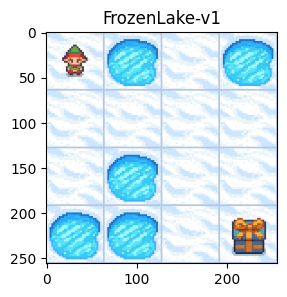

In [2]:
import gym
import time
import numpy as np
from gym.envs.toy_text.frozen_lake import generate_random_map

# 设置随机数种子
np.random.seed(233)

# 创建FrozenLake环境
env = gym.make('FrozenLake-v1', desc=generate_random_map(size=4), is_slippery=False, render_mode="rgb_array")

# 重置环境状态
env.reset()

# 创建GymHelper对象来辅助显示
gym_helper = GymHelper(env)

### Q-Learning

In [3]:
# 初始化参数
num_episodes = 5000 # 总回合数
gamma = 0.99 # 折扣因子
alpha = 0.1 # 学习率

In [4]:
# 根据epsilon-greedy策略选择动作
def choose_action(state, Q, epsilon = 0.1):
    if np.random.rand() < epsilon: # 以epsilon的概率随机选择一个动作
        return np.random.randint(env.action_space.n)
    else: # 否则选择具有最高Q值的动作
        return np.argmax(Q[state])

# 更新Q值表中的值
def q_update_value(state, action, reward, next_state, done, Q):
    if done: # 如果达到终止状态，根据奖励更新Q值
        Q[state][action] += alpha * (reward - Q[state][action])
    else: # 如果未达到终止状态，根据Q-learning公式更新Q值
        Q[state][action] += alpha * (reward + gamma * np.max(Q[next_state]) - Q[state][action])

In [5]:
# 初始化Q值表，形状为环境中状态数量和动作数量
Q = np.zeros((env.observation_space.n, env.action_space.n))
# 记录每个回合的总奖励
total_reward = []

# 开始循环
for i in range(num_episodes):
    # 当前回合的总奖励
    sum_reward = 0
    # 初始化环境并获取初始状态
    state, _ = env.reset()
    
    while True:
        # 根据当前状态选择动作
        action = choose_action(state, Q)
        # 执行动作，获取新的信息
        next_state, reward, terminated, truncated, info = env.step(action)
        # 判断是否达到终止状态
        done = terminated or truncated
        
        # 对于FrozenLake的佛系默认环境，适当调整奖励
        if 'FrozenLake' in env.spec.id:
            if terminated and reward == 1: # 游戏终止且reward为1表示到达终点，给予高额奖励
                reward = 20
            elif terminated and reward == 0: # 游戏终止且reward为0表示掉进冰洞，给予反向奖励
                reward = -20
            else: # 每走一步奖励为-1，其实是鼓励agent尽快完成任务
                reward = -1
        
        # 更新Q值表
        q_update_value(state, action, reward, next_state, done, Q)
        # 累加奖励
        sum_reward += reward
        # 更新当前状态
        state = next_state
        
        if done:
            break
    # 记录当前回合的总奖励
    total_reward.append(sum_reward)

# 打印回合数和最大总奖励
print("Episodes: {0}\nMax Reward: {1}".format(num_episodes, max(total_reward)))

Episodes: 5000
Max Reward: 15


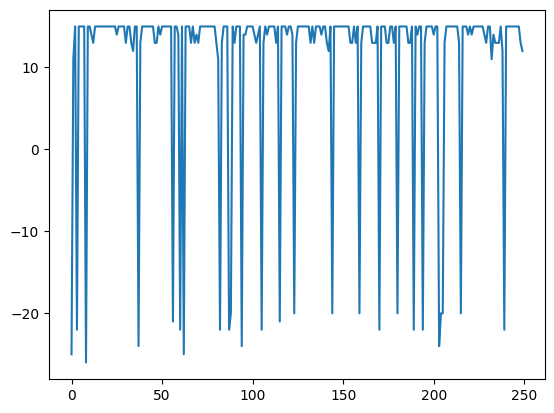

In [6]:
plt.plot(total_reward[::20])

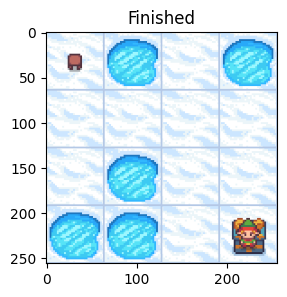

In [7]:
# 重置环境，开始新的一轮游戏
observation, _ = env.reset()
# 创建GymHelper对象来辅助显示
gym_helper = GymHelper(env, figsize = (3, 3))

# 进行10步的游戏
for i in range(20):
    # 渲染环境，title为当前步骤数
    gym_helper.render(title = str(i))
    
    # 通过已经求得的Q值表，找到当前状态下的最优动作
    action = choose_action(observation, Q, epsilon = 0)
    # 执行action，获取新的信息
    observation, reward, terminated, truncated, info = env.step(action)
        
    time.sleep(0.5)
    
    # 如果游戏结束，则结束当前循环
    if terminated or truncated:
        break

# 游戏结束
gym_helper.render(title = "Finished")
# 关闭环境
env.close()

In [8]:
Q

array([[ 12.97759187,  14.11880599, -19.99993542,  12.97760668],
       [  0.        ,   0.        ,   0.        ,   0.        ],
       [ -3.8       ,  16.4357769 ,  -3.8       ,   1.1676162 ],
       [  0.        ,   0.        ,   0.        ,   0.        ],
       [ 14.11879224,  12.97658263,  15.2715212 ,  12.97757855],
       [ 14.11877283, -19.9998333 ,  16.43588   , -19.99997973],
       [ 15.27142302,  17.612     ,  17.61198346,  15.27013776],
       [  2.94718571,  18.8       ,   8.0543957 , -11.3906558 ],
       [  3.16091629,  -9.37118   ,  -6.878     ,  14.11870909],
       [  0.        ,   0.        ,   0.        ,   0.        ],
       [-19.9999722 ,  18.79892286,  18.8       ,  16.43586319],
       [ 17.61191139,  20.        ,  18.79943031,  17.61194834],
       [  0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ],
       [ -6.878     ,   5.02113275,  19.99990156,   3.34628   ],
       [  0.        ,   0

In [9]:
np.array(["左", "下", "右", "上"])[np.argmax(Q.reshape(4, 4, 4), axis = 2)]

array([['下', '左', '下', '左'],
       ['右', '右', '下', '下'],
       ['上', '左', '右', '下'],
       ['左', '左', '右', '左']], dtype='<U1')

### SARSA

In [10]:
# Sarsa算法更新Q值表中的值
def sarsa_update_value(state, action, reward, next_state, next_action, done, Q):
    if done: # 如果达到终止状态，根据奖励更新Q值
        Q[state][action] += alpha * (reward - Q[state][action])
    else: # 如果未达到终止状态，根据Sarsa公式更新Q值
        Q[state][action] += alpha * (reward + gamma * Q[next_state][next_action] - Q[state][action])

In [11]:
# 初始化Q值表，形状为环境中状态数量和动作数量
Q = np.zeros((env.observation_space.n, env.action_space.n))
# 记录每个回合的总奖励
total_reward = []

# 开始循环
for i in range(num_episodes):
    # 当前回合的总奖励
    sum_reward = 0
    # 初始化环境并获取初始状态
    state, _ = env.reset()
    # 根据当前状态选择动作
    action = choose_action(state, Q)
    
    while True:
        # 执行动作，获取新的信息
        next_state, reward, terminated, truncated, info = env.step(action)
        # 判断是否达到终止状态
        done = terminated or truncated
        
        # 对于FrozenLake的佛系默认环境，适当调整奖励
        if 'FrozenLake' in env.spec.id:
            if terminated and reward == 1: # 游戏终止且reward为1表示到达终点，给予高额奖励
                reward = 20
            elif terminated and reward == 0: # 游戏终止且reward为0表示掉进冰洞，给予反向奖励
                reward = -20
            else: # 每走一步奖励为-1，其实是鼓励agent尽快完成任务
                reward = -1
        
        # 根据下一个状态选择下一个动作
        next_action = choose_action(next_state, Q)
        # 更新Q值表
        sarsa_update_value(state, action, reward, next_state, next_action, done, Q)
        # 累加奖励
        sum_reward += reward
        # 更新当前状态及动作
        state, action = next_state, next_action
        
        if done:
            break
    # 记录当前回合的总奖励
    total_reward.append(sum_reward)

# 打印回合数和最大总奖励
print("Episodes: {0}\nMax Reward: {1}".format(num_episodes, max(total_reward)))

Episodes: 5000
Max Reward: 15


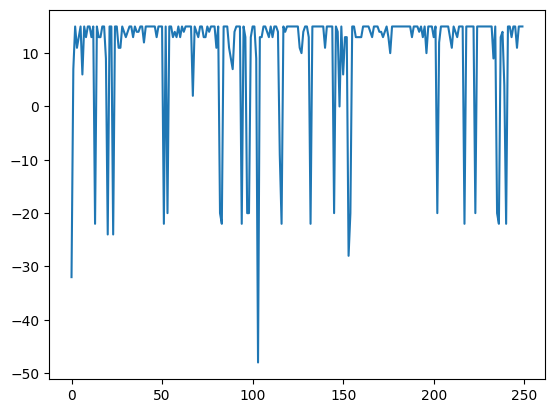

In [12]:
plt.plot(total_reward[::20])

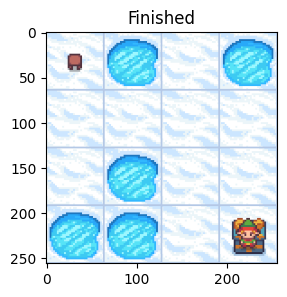

In [16]:
# 重置环境，开始新的一轮游戏
observation, _ = env.reset()
# 创建GymHelper对象来辅助显示
gym_helper = GymHelper(env, figsize = (3, 3))

# 进行10步的游戏
for i in range(20):
    # 渲染环境，title为当前步骤数
    gym_helper.render(title = str(i))
    
    # 通过已经求得的Q值表，找到当前状态下的最优动作
    action = choose_action(observation, Q, 0)
    # 执行action，获取新的信息
    observation, reward, terminated, truncated, info = env.step(action)
        
    time.sleep(0.5)
    
    # 如果游戏结束，则结束当前循环
    if terminated or truncated:
        break

# 游戏结束
gym_helper.render(title = "Finished")
# 关闭环境
env.close()

In [14]:
Q

array([[  6.26841953,   9.93905591, -19.9999982 ,   7.43024693],
       [  0.        ,   0.        ,   0.        ,   0.        ],
       [ -9.37118   ,  14.42222068,  -9.37118   ,   6.33809671],
       [  0.        ,   0.        ,   0.        ,   0.        ],
       [  7.13171512,   4.54438284,  12.40205541,   5.09403121],
       [  8.74976544, -19.99998358,  14.77346304, -19.9999867 ],
       [ 11.39912269,  12.75608627,  16.64436369,  11.99129249],
       [ 14.90959288,  18.7935545 ,  13.72529785, -19.99713318],
       [  0.82129872, -15.88217736, -12.25159022,   8.32576995],
       [  0.        ,   0.        ,   0.        ,   0.        ],
       [-18.56420402,  13.08074603,  18.11242546,  13.79445304],
       [ 14.68376128,  20.        ,  18.31116212,  16.55265906],
       [  0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ],
       [ -2.        ,  -0.19      ,  18.40467114,   0.        ],
       [  0.        ,   0

In [15]:
np.array(["左", "下", "右", "上"])[np.argmax(Q.reshape(4, 4, 4), axis = 2)]

array([['下', '左', '下', '左'],
       ['右', '右', '右', '下'],
       ['上', '左', '右', '下'],
       ['左', '左', '右', '左']], dtype='<U1')